Example code for Task 5: Model Iterations.
This script demonstrates how to:
1. Load a CSV file containing NLP features (from Task 4).
2. Parse columns such as TF-IDF, sentiment scores, custom embeddings, etc.
3. Encode the target emotion labels.
4. Train and evaluate:
   - Logistic Regression
   - Naive Bayes
   - LSTM (Keras/TensorFlow)
   - RNN (Keras/TensorFlow)
   - Two Transformer models (via Hugging Face)

You should adapt paths, filenames, column names, and any language-specific libraries
to match your actual data and environment.

Ensure you record each model's details (features used, hyperparameters, metrics)
in your model iteration file (required by Task 5).

---
## INSTALL REQUIRED LIBRARIES

In [16]:
# !pip install scikit-learn numpy pandas tensorflow torch transformers sentencepiece gensim datasets

import numpy as np
import pandas as pd

# Sklearn for classic models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# TensorFlow/Keras for LSTM, RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Input, Add, Bidirectional

# Hugging Face Transformers
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from transformers import DataCollatorWithPadding

NUM_TEST_SAMPLES = 1049
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## STEP 1: LOAD THE CSV FILE CONTAINING NLP FEATURES

In [2]:
df = pd.read_excel('nlp_balanced.xlsx')
df.dropna(subset=['ru_text', 'general_emotion'], inplace=True)

df.head()

,ru_text,text,emotion,general_emotion,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"О боже, человекХ он здесь, потому что ты не сл...",Omg personX he s there because you don t liste...,anger,anger,"7,3,2,3,5,8,2,8,10,5,9,4,2,5,3,2,0,0,0,0,0,0,0...","0.049742214931586266,0.246067748492145,-0.0193...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,...","-0.0066382606,-0.017590161,-0.018125338,-0.072...","0.030576168,0.27334276,0.0397711,0.15091494,0...."
1,"Могу поспорить, вы устали от того, что люди пр...",I bet you get tired of people looking through ...,annoyance,anger,"4,4,2,5,4,7,5,2,10,3,4,3,11,3,12,4,11,3,2,10,8...","0.014475719013516568,0.00526188809012008,0.003...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...","0.023441149,-0.04532143,0.0023011374,0.0441399...","0.021779323,0.21595497,0.03274918,0.11827041,0..."
2,"А еще был тот, кто схватил маму за грудь и поп...",And then there was the on who grabbed mom s br...,annoyance,anger,"12,8,14,11,2,5,4,3,7,3,12,4,4,5,7,3,3,2,0,0,0,...","0.001305419355379824,0.0013254923030408426,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,...","0.04503659,-0.017458426,0.009537351,-0.0078370...","0.022650253,0.25176293,0.023268355,0.12664051,..."
3,"Уничтожение выгорания. Затем, когда я пытался ...",Burnout takedown. Then when trying to recover ...,disapproval,anger,"3,3,2,8,2,10,5,4,4,7,6,2,5,4,6,3,3,2,0,0,0,0,0...","0.004262502635653441,0.0025379210102163853,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,...","-0.0030044816,-0.039658867,0.022025786,0.01329...","0.017996736,0.22823228,0.031311635,0.11563357,..."
4,Я предпочитаю продолжать вбрасывать деньги в э...,I d rather continue throwing money into these ...,annoyance,anger,"5,4,4,4,3,7,11,6,3,2,10,4,5,7,6,3,3,3,2,0,0,0,...","0.005679983230965895,0.0033794104401030116,0.0...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,...","0.009746693,-0.0066950456,0.034261893,0.030210...","0.021388112,0.248662,0.023290874,0.12458279,0...."


## STEP 2: PARSE FEATURES (TF-IDF, embeddings, etc.)

In [3]:
df['TF_IDF'] = df['TF_IDF'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
df['pretrained_embeddings'] = df['pretrained_embeddings'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
df['custom_embeddings'] = df['custom_embeddings'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
df['pos_tags'] = df['pos_tags'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
df['named_entities'] = df['named_entities'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))

In [4]:
df.head()

,ru_text,text,emotion,general_emotion,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"О боже, человекХ он здесь, потому что ты не сл...",Omg personX he s there because you don t liste...,anger,anger,"[7.0, 3.0, 2.0, 3.0, 5.0, 8.0, 2.0, 8.0, 10.0,...","[0.049742214931586266, 0.246067748492145, -0.0...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[-0.0066382606, -0.017590161, -0.018125338, -0...","[0.030576168, 0.27334276, 0.0397711, 0.1509149..."
1,"Могу поспорить, вы устали от того, что люди пр...",I bet you get tired of people looking through ...,annoyance,anger,"[4.0, 4.0, 2.0, 5.0, 4.0, 7.0, 5.0, 2.0, 10.0,...","[0.014475719013516568, 0.00526188809012008, 0....","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.023441149, -0.04532143, 0.0023011374, 0.044...","[0.021779323, 0.21595497, 0.03274918, 0.118270..."
2,"А еще был тот, кто схватил маму за грудь и поп...",And then there was the on who grabbed mom s br...,annoyance,anger,"[12.0, 8.0, 14.0, 11.0, 2.0, 5.0, 4.0, 3.0, 7....","[0.001305419355379824, 0.0013254923030408426, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.04503659, -0.017458426, 0.009537351, -0.007...","[0.022650253, 0.25176293, 0.023268355, 0.12664..."
3,"Уничтожение выгорания. Затем, когда я пытался ...",Burnout takedown. Then when trying to recover ...,disapproval,anger,"[3.0, 3.0, 2.0, 8.0, 2.0, 10.0, 5.0, 4.0, 4.0,...","[0.004262502635653441, 0.0025379210102163853, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[-0.0030044816, -0.039658867, 0.022025786, 0.0...","[0.017996736, 0.22823228, 0.031311635, 0.11563..."
4,Я предпочитаю продолжать вбрасывать деньги в э...,I d rather continue throwing money into these ...,annoyance,anger,"[5.0, 4.0, 4.0, 4.0, 3.0, 7.0, 11.0, 6.0, 3.0,...","[0.005679983230965895, 0.0033794104401030116, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.009746693, -0.0066950456, 0.034261893, 0.03...","[0.021388112, 0.248662, 0.023290874, 0.1245827..."


In [5]:
len(df['TF_IDF'][0])

3

## STEP 3: ENCODE THE TARGET EMOTION LABEL

In [18]:
label_encoder = LabelEncoder()
df["emotion_encoded"] = label_encoder.fit_transform(df["general_emotion"])
classes_ = label_encoder.classes_
num_classes = len(classes_)
print("Emotion classes:", classes_)

Emotion classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']


In [7]:
# # Save df['ru_text']

# df['ru_text'].to_csv('ru_text.csv', index=False)
# df['emotion_encoded'].to_csv('emotion_encoded.csv', index=False)
# df['text'].to_csv('text.csv', index=False)

## STEP 4: BUILD A FEATURE MATRIX X (FOR CLASSIC MODELS)

In [8]:
import numpy as np
from scipy.sparse import hstack

# Convert each feature column into a NumPy array
X_tfidf = np.vstack(df["TF_IDF"])
X_pretrained = np.vstack(df["pretrained_embeddings"])
X_custom = np.vstack(df["custom_embeddings"])
X_pos = np.vstack(df["pos_tags"])
X_entities = np.vstack(df["named_entities"])

# Combine all features into a single matrix
X = np.hstack([X_pretrained, X_custom, X_pos, X_entities])  # Use hstack for feature fusion
y = df["emotion_encoded"].values  # Convert to NumPy array

print(X.shape, y.shape)  # Check the final shape


(10896, 688) (10896,)


general_emotion
neutral      1934
happiness    1784
surprise     1469
anger        1446
sadness      1429
disgust      1421
fear         1413
Name: count, dtype: int64


8

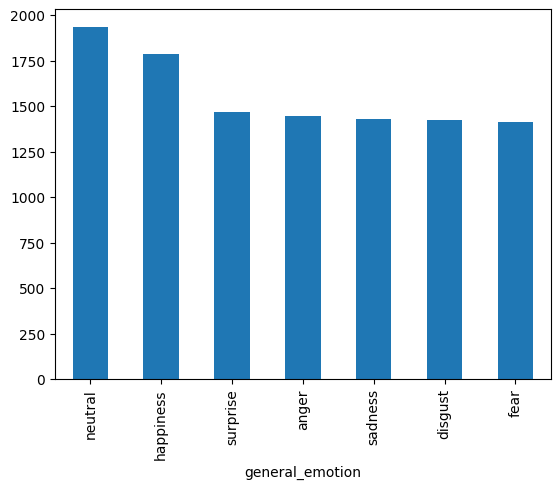

In [9]:
# Bar plot for frequency of emeotions
df["general_emotion"].value_counts().plot(kind="bar")
print(df["general_emotion"].value_counts())

# Difference between 2 smallest classes
df["general_emotion"].value_counts().iloc[-2] - df["general_emotion"].value_counts().iloc[-1]

## STEP 5: SPLIT DATA FOR CLASSIC MODELS (LOGREG, NB)

In [10]:
# Split the data
X_train, X_test = X[:-NUM_TEST_SAMPLES], X[-NUM_TEST_SAMPLES:]
y_train, y_test = y[:-NUM_TEST_SAMPLES], y[-NUM_TEST_SAMPLES:]

# Check the shapes to ensure the split is correct
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9847, 688)
X_test shape: (1049, 688)
y_train shape: (9847,)
y_test shape: (1049,)


## STEP 6: LOGISTIC REGRESSION

In [11]:
print("\n=== Logistic Regression ===")
lr_clf = LogisticRegression(max_iter=300)
# If X is not a standard 2D float array, convert X_train/X_test to lists
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
print("F1 (wighted):", f1_lr)
print(classification_report(y_test, y_pred_lr, target_names=classes_))


=== Logistic Regression ===
F1 (wighted): 0.31190468110410646
              precision    recall  f1-score   support

       anger       0.09      0.08      0.09        37
     disgust       0.02      0.42      0.03        12
        fear       0.03      0.60      0.06         5
   happiness       0.49      0.28      0.35       375
     neutral       0.59      0.23      0.33       525
     sadness       0.06      0.40      0.10        20
    surprise       0.18      0.17      0.17        75

    accuracy                           0.25      1049
   macro avg       0.21      0.31      0.16      1049
weighted avg       0.48      0.25      0.31      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## STEP 7: NAIVE BAYES

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Apply MaxAbsScaler (preserves sparsity)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MultinomialNB on the transformed data
nb_clf = MultinomialNB()
nb_clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_nb = nb_clf.predict(X_test_scaled)
f1_nb = f1_score(y_test, y_pred_nb,  average="weighted")

print("F1 (macro):", f1_nb)
print(classification_report(y_test, y_pred_nb, target_names=classes_))

F1 (macro): 0.06023537251770501
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        37
     disgust       0.01      0.75      0.02        12
        fear       0.02      0.60      0.04         5
   happiness       0.54      0.07      0.13       375
     neutral       0.00      0.00      0.00       525
     sadness       0.00      0.00      0.00        20
    surprise       0.19      0.17      0.18        75

    accuracy                           0.05      1049
   macro avg       0.11      0.23      0.05      1049
weighted avg       0.21      0.05      0.06      1049



## STEP 8: LSTM MODEL (Keras) FOR TEXT

In [8]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, Dropout, LayerNormalization
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import nltk

In [9]:
import re
import pandas as pd
import os
import glob

def clean_text(text):
    # Remove Roman numerals (common chapter indicators) at the start of lines
    text = re.sub(r'^\s*[IVXLCDM]\s*', '', text, flags=re.MULTILINE)
    
    # Remove double dashes "--" from sentences
    text = re.sub(r'\s*--\s*', ' ', text)

    # Remove en letters and special characters
    text = re.sub(r'[^А-Яа-я0-9.,!?;:\s]', '', text)
    
    # Trim leading/trailing spaces
    return text.strip()


def concatenate_text_from_folder(root_folder):
    """Goes through all subfolders and concatenates text from .txt files using glob."""
    all_text = ""

    for txt_file in glob.glob(f"{root_folder}/**/*", recursive=True):
        if os.path.isfile(txt_file):
            with open(txt_file, "r") as file:
                all_text += file.read() + "\n"  # Adding newline to separate files
    
    return all_text

full_text = concatenate_text_from_folder('russian_literature-main/books')

# Split the sentences with \n
sentences = full_text.split('\n')

# Clean the sentences
sentences = [clean_text(sentence) for sentence in sentences if sentence.strip() != ""]

# Delete all senteces with less than 4 characters
sentences = [sentence for sentence in sentences if len(sentence) > 4]

# Make a np array
dostoyevsky_sent = np.array(sentences)

In [10]:
print(dostoyevsky_sent[:5])  # Print first 5 sentences

['Павел Афанасьевич Фамусов, управляющий в казенном месте.'
 'Софья Павловна, его дочь.' 'Лизанька, служанка.'
 'Алексей Степанович Молчалин, секретарь Фамусова, живущий у него в доме.'
 'Александр Андреевич Чацкий.']


In [11]:
texts = df['ru_text'].values
labels = df['emotion_encoded'].values

# add dostoeyevsky sentences to the texts
texts_w2v = np.concatenate([texts, dostoyevsky_sent])

In [12]:
# Tokenization and sequence conversion
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(sequences)
 
# Padding sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
 
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[nltk.word_tokenize(sent, language='russian') for sent in texts_w2v], vector_size=300, window=5, min_count=5, workers=4)
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
 
# Save embeddings to CSV
embedding_df = pd.DataFrame(embedding_matrix)
embedding_df.to_csv("word_embeddings.csv", index=False)

[[26, 204, 8, 15, 80, 47, 2, 20, 4, 8109, 20, 2592], [57, 2120, 18, 4797, 40, 62, 2, 65, 8110, 953, 1537, 8111, 6, 1214, 335, 8112, 39, 61, 1806, 81, 4798, 2593], [33, 42, 37, 182, 55, 4799, 3430, 23, 2121, 6, 4800, 8113, 66, 5, 1012, 1807], [8114, 8115, 414, 24, 1, 671, 8116, 7, 1367, 13, 4801, 4802, 2122, 8117], [1, 1103, 954, 8118, 451, 5, 145, 8119, 8120, 53, 369, 54, 38, 4803, 8121, 8122, 8123], [4804, 23, 155, 39, 2594, 837, 4, 4805, 3, 31, 22, 1104, 8124, 8125, 7, 1215], [18, 95, 233, 788, 66, 4806], [175, 44, 8, 4, 17, 76, 5, 893, 202, 8, 6, 42, 119, 7, 8126, 34, 350, 56, 5, 48, 751, 27, 284, 3431], [8127, 4807, 5, 1808, 8128, 8129, 40, 707, 60, 3432, 5, 2595, 9, 2123, 60, 3433, 6, 1809, 508, 1013], [43, 15, 135, 2, 8130, 156, 14, 588, 386, 838, 5, 1014, 33, 4, 4808, 5, 1014, 3, 1368, 894, 5, 8131], [2124, 8132, 247, 4809, 8133, 8134, 8135], [8136, 1538, 6, 8137, 3, 25, 4810, 955], [607, 8138, 8139, 3, 25, 8140], [8, 509, 109, 8141, 215, 789, 2596, 9, 8142], [45, 1539, 4, 191, 

INFO: collecting all words and their counts
INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO: PROGRESS: at sentence #10000, processed 143576 words, keeping 25229 word types
INFO: PROGRESS: at sentence #20000, processed 380471 words, keeping 58607 word types
INFO: PROGRESS: at sentence #30000, processed 868297 words, keeping 102095 word types
INFO: PROGRESS: at sentence #40000, processed 1242661 words, keeping 122766 word types
INFO: PROGRESS: at sentence #50000, processed 1608680 words, keeping 138170 word types
INFO: PROGRESS: at sentence #60000, processed 1880750 words, keeping 148624 word types
INFO: PROGRESS: at sentence #70000, processed 1959695 words, keeping 154539 word types
INFO: PROGRESS: at sentence #80000, processed 2061097 words, keeping 160779 word types
INFO: PROGRESS: at sentence #90000, processed 2145719 words, keeping 166069 word types
INFO: PROGRESS: at sentence #100000, processed 2221979 words, keeping 170186 word types
INFO: PROGRESS: at

### LSTM 1

In [62]:
# Load embeddings from CSV
loaded_embedding_matrix = pd.read_csv("word_embeddings.csv").values

# Split data
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)
 
def create_model_lstm_1():
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(vocab_size, 300, weights=[loaded_embedding_matrix], input_length=max_length, trainable=False),
        LSTM(256, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(len(classes_), activation='softmax')
    ]
    ,name="lstm_1")
    
    adam = tf.keras.optimizers.AdamW(learning_rate=5e-4)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='weighted')])
    model.summary()
    
    return model

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch > 3:
        return lr * float(tf.math.exp(-0.15))
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Number of K folds
k = 5  # You can change this number based on your needs

# Initialize KFold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

fold_no = 1
for train_index, val_index in kf.split(X_train):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = np.array(y_train)[train_index], np.array(y_train)[val_index]
    
    print(f"Training fold {fold_no} of {k}...")
    
    # Initialize the model (make sure it's re-initialized for each fold)
    model = create_model_lstm_1()  # Replace with your model creation function
    
    # Train the model on the fold
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping, lr_scheduler],
                        verbose=1)
    
    # Find the epoch where early stopping occurred
    best_epoch = np.argmin(history.history['val_loss'])  # The epoch with the minimum validation loss
    # Capture the metrics at the best epoch
    train_losses.append(history.history['loss'][best_epoch])  # Training loss at best epoch
    val_losses.append(history.history['val_loss'][best_epoch])  # Validation loss at best epoch
    train_accuracies.append(history.history['f1_score'][best_epoch])  # Training accuracy at best epoch
    val_accuracies.append(history.history['val_f1_score'][best_epoch])  # Validation accuracy at best epoch
    
    fold_no += 1

# Calculate averages for each metric
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)

print("\nAverage results across all folds:")
print(f"Average training loss: {avg_train_loss}")
print(f"Average validation loss: {avg_val_loss}")
print(f"Average training f1_score: {avg_train_accuracy}")
print(f"Average validation f1_score: {avg_val_accuracy}")


Training fold 1 of 5...


/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 37, 300)        │     7,138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,175 (29.56 MB)

 Trainable params: 611,975 (2.33 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - f1_score: 0.1291 - loss: 1.9404 - val_f1_score: 0.1394 - val_loss: 1.9186 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.1922 - loss: 1.8908 - val_f1_score: 0.1849 - val_loss: 1.8778 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2245 - loss: 1.8396 - val_f1_score: 0.2095 - val_loss: 1.8284 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.2614 - loss: 1.7817 - val_f1_score: 0.2742 - val_loss: 1.7822 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.3123 - loss: 1.7100 - val_f1_score: 0.2829 - val_loss: 1.7591 - learning_rate: 4.3035e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.3563 - loss: 1.6415 - val_f1_score: 0.3287 - val_loss: 1.7275 - learning_rate: 3.7041e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - f1_score:

Model: "lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 37, 300)        │     7,138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,175 (29.56 MB)

 Trainable params: 611,975 (2.33 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - f1_score: 0.1156 - loss: 1.9412 - val_f1_score: 0.1237 - val_loss: 1.9272 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.1783 - loss: 1.9057 - val_f1_score: 0.1986 - val_loss: 1.8795 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.2060 - loss: 1.8511 - val_f1_score: 0.2074 - val_loss: 1.8286 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2501 - loss: 1.7953 - val_f1_score: 0.2003 - val_loss: 1.8413 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.2801 - loss: 1.7502 - val_f1_score: 0.2754 - val_loss: 1.8001 - learning_rate: 4.3035e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.3085 - loss: 1.6875 - val_f1_score: 0.2736 - val_loss: 1.8418 - learning_rate: 3.7041e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 

Model: "lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 37, 300)        │     7,138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,175 (29.56 MB)

 Trainable params: 611,975 (2.33 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - f1_score: 0.1190 - loss: 1.9429 - val_f1_score: 0.1326 - val_loss: 1.9370 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.1767 - loss: 1.9118 - val_f1_score: 0.1919 - val_loss: 1.9046 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2310 - loss: 1.8515 - val_f1_score: 0.2181 - val_loss: 1.8602 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2560 - loss: 1.7990 - val_f1_score: 0.2263 - val_loss: 1.8261 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2940 - loss: 1.7403 - val_f1_score: 0.2870 - val_loss: 1.7932 - learning_rate: 4.3035e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.3404 - loss: 1.6705 - val_f1_score: 0.2856 - val_loss: 1.8027 - learning_rate: 3.7041e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 

Model: "lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 37, 300)        │     7,138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,175 (29.56 MB)

 Trainable params: 611,975 (2.33 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - f1_score: 0.1239 - loss: 1.9392 - val_f1_score: 0.1571 - val_loss: 1.9195 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.1673 - loss: 1.8938 - val_f1_score: 0.1768 - val_loss: 1.8722 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2186 - loss: 1.8489 - val_f1_score: 0.2029 - val_loss: 1.8333 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1_score: 0.2604 - loss: 1.8095 - val_f1_score: 0.2501 - val_loss: 1.7959 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.3149 - loss: 1.7325 - val_f1_score: 0.2649 - val_loss: 1.7956 - learning_rate: 4.3035e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.3553 - loss: 1.6614 - val_f1_score: 0.2856 - val_loss: 1.7762 - learning_rate: 3.7041e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score:

Model: "lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (None, 37, 300)        │     7,138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,175 (29.56 MB)

 Trainable params: 611,975 (2.33 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - f1_score: 0.1271 - loss: 1.9400 - val_f1_score: 0.1290 - val_loss: 1.9213 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.1875 - loss: 1.8913 - val_f1_score: 0.1685 - val_loss: 1.8701 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2308 - loss: 1.8269 - val_f1_score: 0.2182 - val_loss: 1.8288 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score: 0.2661 - loss: 1.7609 - val_f1_score: 0.2568 - val_loss: 1.8122 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - f1_score: 0.3167 - loss: 1.6912 - val_f1_score: 0.2921 - val_loss: 1.8070 - learning_rate: 4.3035e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - f1_score: 0.3665 - loss: 1.6057 - val_f1_score: 0.2737 - val_loss: 1.8301 - learning_rate: 3.7041e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_score:

In [64]:
# Predict and evaluate
y_pred_lstm = model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (macro):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1 (macro): 0.32400991156602826
              precision    recall  f1-score   support

       anger       0.07      0.14      0.09        37
     disgust       0.02      0.25      0.04        12
        fear       0.10      0.40      0.15         5
   happiness       0.48      0.16      0.24       375
     neutral       0.64      0.35      0.45       525
     sadness       0.02      0.15      0.04        20
    surprise       0.07      0.27      0.12        75

    accuracy                           0.26      1049
   macro avg       0.20      0.24      0.16      1049
weighted avg       0.50      0.26      0.32      1049



In [ ]:
model.save('lstm_300_emb_simple+512layer+dropout.keras')

### LSTM 2


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Add

# Load embeddings from CSV
loaded_embedding_matrix = pd.read_csv("word_embeddings.csv").values

# Ensure embedding matrix shape matches vocab_size and embedding dimension (100)
vocab_size, embedding_dim = loaded_embedding_matrix.shape
assert embedding_dim == 300, "Embedding dimension mismatch."

# Split data (assuming padded_sequences and labels are already defined and shuffled)
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# # Split train into train and val
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
# y_val = tf.keras.utils.to_categorical(y_val)

def create_model_lstm_2():
    # Input Layer
    inputs = Input(shape=(max_length,))
    emb = Embedding(vocab_size, 300, weights=[loaded_embedding_matrix], trainable=False)(inputs)
    
    # Bidirectional LSTM Layer 1
    x = Bidirectional(LSTM(512, return_sequences=True))(emb)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Residual Block - LSTM 2
    residual1 = x  # Save for residual connection
    x = Bidirectional(LSTM(256, return_sequences=True))(emb)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    residual1 = Dense(512)(residual1)
    x = Add()([x, residual1])  # Residual connection
    
    # Residual Block - LSTM 3
    residual2 = x  # Save for residual connection
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    residual2 = Dense(256)(residual2)
    x = Add()([x, residual2])  # Residual connection
    
    # LSTM 4 
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Dense Layer
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model Compilation
    model = tf.keras.models.Model(inputs, outputs, name="lstm_2")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss='categorical_crossentropy',
        metrics=[tf.metrics.F1Score(average='weighted', name='f1_score')]
    )
    
    model.summary()
    
    return model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch > 3:
        return lr * float(tf.math.exp(-0.18))
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Number of K folds
k = 5  # You can change this number based on your needs

# Initialize KFold cross-validation
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

fold_no = 1
for train_index, val_index in kf.split(X_train, y_train.argmax(axis=1)):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = np.array(y_train)[train_index], np.array(y_train)[val_index]
    
    print(f"Training fold {fold_no} of {k}...")
    
    # Initialize the model (make sure it's re-initialized for each fold)
    model = create_model_lstm_2()  # Replace with your model creation function
    
    # Train the model on the fold
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping, lr_scheduler],
                        verbose=1)
    
    # Find the epoch where early stopping occurred
    best_epoch = np.argmin(history.history['val_loss'])  # The epoch with the minimum validation loss
    # Capture the metrics at the best epoch
    train_losses.append(history.history['loss'][best_epoch])  # Training loss at best epoch
    val_losses.append(history.history['val_loss'][best_epoch])  # Validation loss at best epoch
    train_accuracies.append(history.history['f1_score'][best_epoch])  # Training accuracy at best epoch
    val_accuracies.append(history.history['val_f1_score'][best_epoch])  # Validation accuracy at best epoch
    
    fold_no += 1

# Calculate averages for each metric
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)

print("\nAverage results across all folds:")
print(f"Average training loss: {avg_train_loss}")
print(f"Average validation loss: {avg_val_loss}")
print(f"Average training f1_score: {avg_train_accuracy}")
print(f"Average validation f1_score: {avg_val_accuracy}")


Training fold 1 of 5...


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_33        │ (None, 37, 300)   │  7,138,200 │ input_layer_33[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 37, 1024)  │  3,330,048 │ embedding_33[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (None, 37, 512)   │  1,140,736 │ embedding_33[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 37, 1024)  │          0 │ bidirectional_24… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 37, 512)   │          0 │ bidirectional_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 1024)  │      2,048 │ dropout_83[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 512)   │      1,024 │ dropout_84[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 37, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 37, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_103[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_26    │ (None, 37, 256)   │    656,384 │ add_12[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 37, 256)   │          0 │ bidirectional_26… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 256)   │        512 │ dropout_85[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 37, 256)   │    131,328 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 37, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_104[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (None, 128)       │    164,352 │ add_13[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 128)       │          0 │ bidirectional_27… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,094,047 (49.95 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - f1_score: 0.1446 - loss: 2.0206 - val_f1_score: 0.1603 - val_loss: 1.9180 - learning_rate: 2.0000e-04
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - f1_score: 0.1692 - loss: 1.9070 - val_f1_score: 0.1761 - val_loss: 1.9154 - learning_rate: 2.0000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - f1_score: 0.1814 - loss: 1.8880 - val_f1_score: 0.1929 - val_loss: 1.8779 - learning_rate: 2.0000e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - f1_score: 0.1970 - loss: 1.8738 - val_f1_score: 0.2040 - val_loss: 1.8398 - learning_rate: 2.0000e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - f1_score: 0.2093 - loss: 1.8152 - val_f1_score: 0.2180 - val_loss: 1.8157 - learning_rate: 1.6705e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - f1_score: 0.2232 - loss: 1.7698 - val_f1_score: 0.2318 - val_loss: 1.7886 - learning_rate: 1.3954e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - f1

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_34        │ (None, 37, 300)   │  7,138,200 │ input_layer_34[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (None, 37, 1024)  │  3,330,048 │ embedding_34[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_29    │ (None, 37, 512)   │  1,140,736 │ embedding_34[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 37, 1024)  │          0 │ bidirectional_28… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 37, 512)   │          0 │ bidirectional_29… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 1024)  │      2,048 │ dropout_88[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 512)   │      1,024 │ dropout_89[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 37, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 37, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_107[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_30    │ (None, 37, 256)   │    656,384 │ add_14[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 37, 256)   │          0 │ bidirectional_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 256)   │        512 │ dropout_90[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 37, 256)   │    131,328 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 37, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_108[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_31    │ (None, 128)       │    164,352 │ add_15[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 128)       │          0 │ bidirectional_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,094,047 (49.95 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - f1_score: 0.1664 - loss: 1.9986 - val_f1_score: 0.1725 - val_loss: 1.9085 - learning_rate: 2.0000e-04
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - f1_score: 0.1802 - loss: 1.9131 - val_f1_score: 0.1880 - val_loss: 1.8836 - learning_rate: 2.0000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - f1_score: 0.1888 - loss: 1.8895 - val_f1_score: 0.1991 - val_loss: 1.8576 - learning_rate: 2.0000e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - f1_score: 0.2028 - loss: 1.8670 - val_f1_score: 0.2130 - val_loss: 1.8540 - learning_rate: 2.0000e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - f1_score: 0.2162 - loss: 1.8416 - val_f1_score: 0.2250 - val_loss: 1.8211 - learning_rate: 1.6705e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - f1_score: 0.2273 - loss: 1.8034 - val_f1_score: 0.2360 - val_loss: 1.7872 - learning_rate: 1.3954e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - f1

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_35        │ (None, 37, 300)   │  7,138,200 │ input_layer_35[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_32    │ (None, 37, 1024)  │  3,330,048 │ embedding_35[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_33    │ (None, 37, 512)   │  1,140,736 │ embedding_35[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 37, 1024)  │          0 │ bidirectional_32… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 37, 512)   │          0 │ bidirectional_33… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 1024)  │      2,048 │ dropout_93[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 512)   │      1,024 │ dropout_94[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 37, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 37, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_111[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_34    │ (None, 37, 256)   │    656,384 │ add_16[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 37, 256)   │          0 │ bidirectional_34… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 256)   │        512 │ dropout_95[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 37, 256)   │    131,328 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 37, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_35    │ (None, 128)       │    164,352 │ add_17[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 128)       │          0 │ bidirectional_35… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,094,047 (49.95 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - f1_score: 0.1639 - loss: 1.9807 - val_f1_score: 0.1748 - val_loss: 1.9198 - learning_rate: 2.0000e-04
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - f1_score: 0.1742 - loss: 1.9195 - val_f1_score: 0.1789 - val_loss: 1.9014 - learning_rate: 2.0000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - f1_score: 0.1823 - loss: 1.8872 - val_f1_score: 0.1920 - val_loss: 1.8974 - learning_rate: 2.0000e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - f1_score: 0.1939 - loss: 1.8749 - val_f1_score: 0.1997 - val_loss: 1.8547 - learning_rate: 2.0000e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - f1_score: 0.2036 - loss: 1.8303 - val_f1_score: 0.2124 - val_loss: 1.8101 - learning_rate: 1.6705e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - f1_score: 0.2173 - loss: 1.7857 - val_f1_score: 0.2253 - val_loss: 1.7894 - learning_rate: 1.3954e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - f1

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_36        │ (None, 37, 300)   │  7,138,200 │ input_layer_36[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_36    │ (None, 37, 1024)  │  3,330,048 │ embedding_36[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_37    │ (None, 37, 512)   │  1,140,736 │ embedding_36[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 37, 1024)  │          0 │ bidirectional_36… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_99          │ (None, 37, 512)   │          0 │ bidirectional_37… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 1024)  │      2,048 │ dropout_98[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 512)   │      1,024 │ dropout_99[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 37, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 37, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_115[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_38    │ (None, 37, 256)   │    656,384 │ add_18[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_100         │ (None, 37, 256)   │          0 │ bidirectional_38… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 256)   │        512 │ dropout_100[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 37, 256)   │    131,328 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 37, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_116[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_39    │ (None, 128)       │    164,352 │ add_19[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_101         │ (None, 128)       │          0 │ bidirectional_39… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,094,047 (49.95 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - f1_score: 0.1600 - loss: 1.9890 - val_f1_score: 0.1872 - val_loss: 1.9041 - learning_rate: 2.0000e-04
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - f1_score: 0.1940 - loss: 1.8944 - val_f1_score: 0.2033 - val_loss: 1.8945 - learning_rate: 2.0000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - f1_score: 0.2019 - loss: 1.8777 - val_f1_score: 0.2103 - val_loss: 1.8418 - learning_rate: 2.0000e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - f1_score: 0.2130 - loss: 1.8243 - val_f1_score: 0.2218 - val_loss: 1.8390 - learning_rate: 2.0000e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - f1_score: 0.2243 - loss: 1.7991 - val_f1_score: 0.2341 - val_loss: 1.7908 - learning_rate: 1.6705e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - f1_score: 0.2362 - loss: 1.7598 - val_f1_score: 0.2456 - val_loss: 1.7761 - learning_rate: 1.3954e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - f1

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_37        │ (None, 37, 300)   │  7,138,200 │ input_layer_37[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_40    │ (None, 37, 1024)  │  3,330,048 │ embedding_37[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_41    │ (None, 37, 512)   │  1,140,736 │ embedding_37[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 37, 1024)  │          0 │ bidirectional_40… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 37, 512)   │          0 │ bidirectional_41… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 1024)  │      2,048 │ dropout_103[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 512)   │      1,024 │ dropout_104[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 37, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 37, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_119[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_42    │ (None, 37, 256)   │    656,384 │ add_20[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 37, 256)   │          0 │ bidirectional_42… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 37, 256)   │        512 │ dropout_105[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 37, 256)   │    131,328 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 37, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_120[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_43    │ (None, 128)       │    164,352 │ add_21[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_106         │ (None, 128)       │          0 │ bidirectional_43… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,094,047 (49.95 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 7,138,200 (27.23 MB)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - f1_score: 0.1508 - loss: 1.9934 - val_f1_score: 0.1723 - val_loss: 1.9120 - learning_rate: 2.0000e-04
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - f1_score: 0.1721 - loss: 1.9198 - val_f1_score: 0.1867 - val_loss: 1.8601 - learning_rate: 2.0000e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - f1_score: 0.1904 - loss: 1.8904 - val_f1_score: 0.1983 - val_loss: 1.8391 - learning_rate: 2.0000e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - f1_score: 0.2024 - loss: 1.8604 - val_f1_score: 0.2122 - val_loss: 1.8842 - learning_rate: 2.0000e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - f1_score: 0.2140 - loss: 1.8479 - val_f1_score: 0.2230 - val_loss: 1.8146 - learning_rate: 1.6705e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - f1_score: 0.2263 - loss: 1.7861 - val_f1_score: 0.2356 - val_loss: 1.7930 - learning_rate: 1.3954e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - f1

In [30]:
# Predict and evaluate
y_pred_lstm = model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (macro):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1 (macro): 0.26813771694428706
              precision    recall  f1-score   support

       anger       0.08      0.32      0.13        37
     disgust       0.02      0.42      0.03        12
        fear       0.00      0.00      0.00         5
   happiness       0.45      0.43      0.44       375
     neutral       0.60      0.13      0.21       525
     sadness       0.00      0.00      0.00        20
    surprise       0.00      0.00      0.00        75

    accuracy                           0.24      1049
   macro avg       0.16      0.19      0.12      1049
weighted avg       0.47      0.24      0.27      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

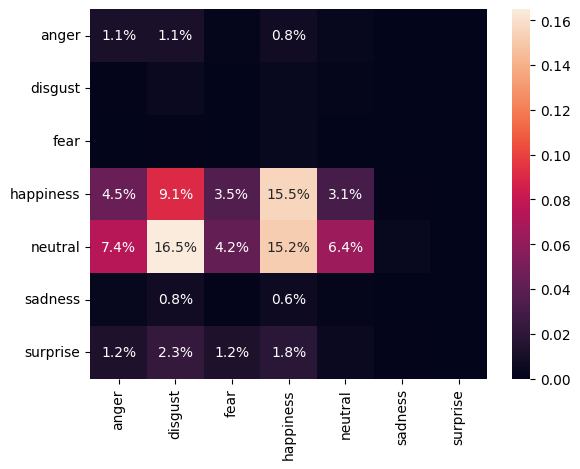

In [31]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)
norm_cm = cm / np.sum(cm)

# Create annotation text: if value is 0%, show empty string; otherwise, show percentage formatted string
annot = np.where(norm_cm < 0.005, "", np.char.mod('%.1f%%', norm_cm * 100))

sns.heatmap(norm_cm, annot=annot, fmt='', xticklabels=classes_, yticklabels=classes_)

In [32]:
model.save('lstm_100_emb_bidir+256+128+64layer+dropout.keras')

### LSTM 3

In [33]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
rubert = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

device = torch.device("cuda")
rubert.to(device)

# Function to get BERT embeddings
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        model_output = model(**{k: v.to(device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]  # CLS token
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()  # Keep batch dimension

print(embed_bert_cls('привет мир', rubert, tokenizer).shape)
# (312,)

(1, 312)


In [34]:
texts = df['ru_text'].tolist()

# Extract embeddings for all texts
embeddings = np.array([embed_bert_cls(text, rubert, tokenizer) for text in tqdm(texts)])

  0%|          | 0/10896 [00:00<?, ?it/s]

100%|██████████| 10896/10896 [00:18<00:00, 602.89it/s]


In [75]:
labels = df['emotion_encoded'].values

# Split data
X_train, X_test = embeddings[:-NUM_TEST_SAMPLES], embeddings[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

def create_model_lstm_3():
    # Input Layer
    inputs = Input(shape=(1, 312))

    # Bidirectional LSTM Layer 1
    x = Bidirectional(LSTM(256, activation='tanh', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(inputs)
    x = tf.keras.layers.LayerNormalization()(x)

    # Residual Block - LSTM 2
    residual = x  # Save for residual connection
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    residual = Dense(256)(residual) 
    x = Add()([x, residual])  # Residual connection

    # LSTM 3
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = tf.keras.layers.LayerNormalization()(x)

    # Dense Layer
    x = Dense(32, activation='tanh')(x)
    x = Dropout(0.2)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model Compilation
    model = tf.keras.models.Model(inputs, outputs, name="lstm_3")

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.F1Score(average='weighted')])

    model.summary()

    return model

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch > 3:
        return lr * float(tf.math.exp(-0.2))
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Number of K folds
k = 5  # You can change this number based on your needs

# Initialize KFold cross-validation
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

fold_no = 1
for train_index, val_index in kf.split(X_train, y_train.argmax(axis=1)):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = np.array(y_train)[train_index], np.array(y_train)[val_index]
    
    print(f"Training fold {fold_no} of {k}...")
    
    # Initialize the model (make sure it's re-initialized for each fold)
    model = create_model_lstm_3()  # Replace with your model creation function
    
    # Train the model on the fold
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping, lr_scheduler],
                        verbose=1)
    
    # Find the epoch where early stopping occurred
    best_epoch = np.argmin(history.history['val_loss'])  # The epoch with the minimum validation loss
    # Capture the metrics at the best epoch
    train_losses.append(history.history['loss'][best_epoch])  # Training loss at best epoch
    val_losses.append(history.history['val_loss'][best_epoch])  # Validation loss at best epoch
    train_accuracies.append(history.history['f1_score'][best_epoch])  # Training accuracy at best epoch
    val_accuracies.append(history.history['val_f1_score'][best_epoch])  # Validation accuracy at best epoch
    
    fold_no += 1

# Calculate averages for each metric
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)

print("\nAverage results across all folds:")
print(f"Average training loss: {avg_train_loss}")
print(f"Average validation loss: {avg_val_loss}")
print(f"Average training f1_score: {avg_train_accuracy}")
print(f"Average validation f1_score: {avg_val_accuracy}")


Training fold 1 of 5...


Model: "lstm_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 1, 312)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_50    │ (None, 1, 512)    │  1,165,312 │ input_layer_40[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ bidirectional_50… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_51    │ (None, 1, 256)    │    656,384 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ bidirectional_51… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_129 (Dense)   │ (None, 1, 256)    │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_129[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_52    │ (None, 128)       │    164,352 │ add_24[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_52… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 32)        │      4,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_110         │ (None, 32)        │          0 │ dense_130[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 7)         │        231 │ dropout_110[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,123,527 (8.10 MB)

 Trainable params: 2,123,527 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - f1_score: 0.2983 - loss: 1.8226 - val_f1_score: 0.4573 - val_loss: 1.4391 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.4621 - loss: 1.4695 - val_f1_score: 0.4902 - val_loss: 1.4107 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.4887 - loss: 1.3922 - val_f1_score: 0.5006 - val_loss: 1.4058 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5151 - loss: 1.3444 - val_f1_score: 0.5115 - val_loss: 1.3655 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5325 - loss: 1.2672 - val_f1_score: 0.4875 - val_loss: 1.3880 - learning_rate: 4.0937e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5717 - loss: 1.1894 - val_f1_score: 0.4938 - val_loss: 1.3932 - learning_rate: 3.3516e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1

Model: "lstm_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 1, 312)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_53    │ (None, 1, 512)    │  1,165,312 │ input_layer_41[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ bidirectional_53… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_54    │ (None, 1, 256)    │    656,384 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ bidirectional_54… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 1, 256)    │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_55    │ (None, 128)       │    164,352 │ add_25[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_55… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 32)        │      4,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_111         │ (None, 32)        │          0 │ dense_133[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 7)         │        231 │ dropout_111[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,123,527 (8.10 MB)

 Trainable params: 2,123,527 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - f1_score: 0.2914 - loss: 1.8803 - val_f1_score: 0.4483 - val_loss: 1.4704 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.4542 - loss: 1.4833 - val_f1_score: 0.4764 - val_loss: 1.4252 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1_score: 0.4845 - loss: 1.3954 - val_f1_score: 0.4689 - val_loss: 1.4458 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.5157 - loss: 1.3318 - val_f1_score: 0.4735 - val_loss: 1.4250 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.5359 - loss: 1.2668 - val_f1_score: 0.4860 - val_loss: 1.4296 - learning_rate: 4.0937e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.5666 - loss: 1.2017 - val_f1_score: 0.4862 - val_loss: 1.4350 - learning_rate: 3.3516e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1

Model: "lstm_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 1, 312)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_56    │ (None, 1, 512)    │  1,165,312 │ input_layer_42[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ bidirectional_56… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_57    │ (None, 1, 256)    │    656,384 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ bidirectional_57… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 1, 256)    │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_135[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_58    │ (None, 128)       │    164,352 │ add_26[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_58… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 32)        │      4,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_112         │ (None, 32)        │          0 │ dense_136[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 7)         │        231 │ dropout_112[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,123,527 (8.10 MB)

 Trainable params: 2,123,527 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - f1_score: 0.2855 - loss: 1.9045 - val_f1_score: 0.4480 - val_loss: 1.4622 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.4481 - loss: 1.5096 - val_f1_score: 0.4682 - val_loss: 1.4305 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.4861 - loss: 1.4241 - val_f1_score: 0.4746 - val_loss: 1.4001 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5096 - loss: 1.3262 - val_f1_score: 0.4870 - val_loss: 1.3935 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1_score: 0.5378 - loss: 1.2735 - val_f1_score: 0.4855 - val_loss: 1.4242 - learning_rate: 4.0937e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5587 - loss: 1.2165 - val_f1_score: 0.5002 - val_loss: 1.4155 - learning_rate: 3.3516e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1

Model: "lstm_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 1, 312)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_59    │ (None, 1, 512)    │  1,165,312 │ input_layer_43[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ bidirectional_59… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_60    │ (None, 1, 256)    │    656,384 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ bidirectional_60… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 1, 256)    │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_138[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_61    │ (None, 128)       │    164,352 │ add_27[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_61… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 32)        │      4,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_113         │ (None, 32)        │          0 │ dense_139[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 7)         │        231 │ dropout_113[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,123,527 (8.10 MB)

 Trainable params: 2,123,527 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - f1_score: 0.2938 - loss: 1.8474 - val_f1_score: 0.4481 - val_loss: 1.4387 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1_score: 0.4470 - loss: 1.5025 - val_f1_score: 0.4888 - val_loss: 1.3843 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.4893 - loss: 1.4010 - val_f1_score: 0.4855 - val_loss: 1.4225 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - f1_score: 0.5115 - loss: 1.3533 - val_f1_score: 0.4870 - val_loss: 1.3871 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - f1_score: 0.5370 - loss: 1.2705 - val_f1_score: 0.4834 - val_loss: 1.3866 - learning_rate: 4.0937e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.5633 - loss: 1.2199 - val_f1_score: 0.4943 - val_loss: 1.3662 - learning_rate: 3.3516e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1

Model: "lstm_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 1, 312)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_62    │ (None, 1, 512)    │  1,165,312 │ input_layer_44[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ bidirectional_62… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_63    │ (None, 1, 256)    │    656,384 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 256)    │        512 │ bidirectional_63… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 1, 256)    │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 1, 256)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_141[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_64    │ (None, 128)       │    164,352 │ add_28[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_64… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 32)        │      4,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_114         │ (None, 32)        │          0 │ dense_142[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_143 (Dense)   │ (None, 7)         │        231 │ dropout_114[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,123,527 (8.10 MB)

 Trainable params: 2,123,527 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - f1_score: 0.2843 - loss: 1.8721 - val_f1_score: 0.4719 - val_loss: 1.4205 - learning_rate: 5.0000e-04
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - f1_score: 0.4307 - loss: 1.5323 - val_f1_score: 0.4793 - val_loss: 1.3782 - learning_rate: 5.0000e-04
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.4665 - loss: 1.4553 - val_f1_score: 0.4850 - val_loss: 1.3694 - learning_rate: 5.0000e-04
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - f1_score: 0.4948 - loss: 1.3828 - val_f1_score: 0.4945 - val_loss: 1.3557 - learning_rate: 5.0000e-04
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - f1_score: 0.5096 - loss: 1.3286 - val_f1_score: 0.5052 - val_loss: 1.3552 - learning_rate: 4.0937e-04
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1_score: 0.5455 - loss: 1.2466 - val_f1_score: 0.5050 - val_loss: 1.3567 - learning_rate: 3.3516e-04
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - f1

In [80]:
# Predict and evaluate
y_pred_lstm = model.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (macro):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
F1 (macro): 0.5706443626133475
              precision    recall  f1-score   support

       anger       0.05      0.05      0.05        37
     disgust       0.04      0.08      0.05        12
        fear       0.17      0.40      0.24         5
   happiness       0.68      0.59      0.63       375
     neutral       0.70      0.58      0.63       525
     sadness       0.25      0.25      0.25        20
    surprise       0.18      0.47      0.26        75

    accuracy                           0.54      1049
   macro avg       0.30      0.35      0.30      1049
weighted avg       0.62      0.54      0.57      1049



<Axes: >

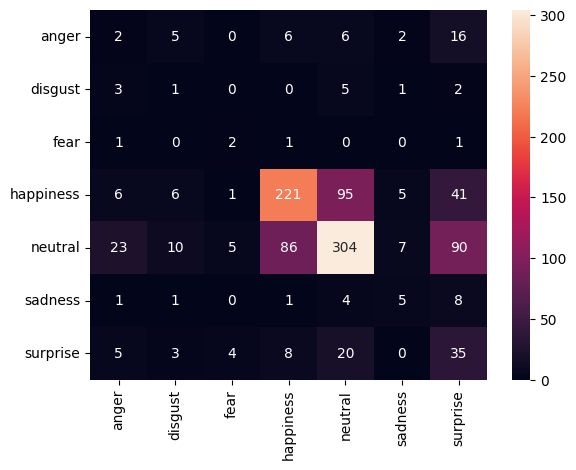

In [83]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)

# # Create annotation text: if value is 0%, show empty string; otherwise, show percentage formatted string
# annot = np.where(norm_cm < 0.001, "", np.char.mod('%.1f%%', norm_cm * 100))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

## STEP 9: RNN MODEL (Keras) FOR TEXT

In [ ]:
# Tokenization and sequence conversion
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(sequences)
 
# Padding sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
 
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
 
# Save embeddings to CSV
embedding_df = pd.DataFrame(embedding_matrix)
embedding_df.to_csv("word_embeddings.csv", index=False)
 
# Load embeddings from CSV
loaded_embedding_matrix = pd.read_csv("word_embeddings.csv").values
 
# Split data
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
 
# Build RNN Model
model = Sequential([
    Embedding(vocab_size, 100, weights=[loaded_embedding_matrix], input_length=max_length, trainable=False),
    SimpleRNN(256, activation='tanh', return_sequences=False),
    Dense(len(classes_), activation='softmax')
])
 
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='weighted')])
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, np.array(y_train), epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
# Predict and evaluate
y_pred_rnn = model.predict(X_test)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
f1_rnn = f1_score(np.argmax(y_test, axis=1), y_pred_rnn, average="weighted")
print("F1 (macro):", f1_rnn)
print(classification_report(np.argmax(y_test, axis=1), y_pred_rnn, target_names=classes_))

## STEP 10: TRANSFORMER MODEL #1 (Example: BERT)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

In [8]:
# import pandas as pd
# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # --- Split the dataset into training+validation and test sets (from the original unbalanced data)
# X_all = df['ru_text'].values
# y_all = df['emotion_encoded'].values

# # Define number of test samples or use a fraction (e.g., 20% test set)
# X_train_unbal, X_test, y_train_unbal, y_test = train_test_split(
#     X_all, y_all, test_size=NUM_TEST_SAMPLES, random_state=42, stratify=y_all)

# # --- Create a DataFrame for training data and balance it
# df_train = pd.DataFrame({'text': X_train_unbal, 'emotion_encoded': y_train_unbal})
# min_class_size = df_train['emotion_encoded'].value_counts().min()

# sampled_dfs = []
# for label in df_train['emotion_encoded'].unique():
#     class_df = df_train[df_train['emotion_encoded'] == label]
#     sampled_dfs.append(resample(class_df, replace=False, n_samples=min_class_size, random_state=42))
# df_train_balanced = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# # Extract balanced training data
# X_train_bal = df_train_balanced['text'].values
# y_train_bal = df_train_balanced['emotion_encoded'].values

# # --- Split the balanced training data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_bal, y_train_bal, test_size=0.1, random_state=42, stratify=y_train_bal)

# # --- Convert labels to categorical (one-hot encoding)
# y_train = tf.keras.utils.to_categorical(y_train)
# y_val   = tf.keras.utils.to_categorical(y_val)
# y_test  = tf.keras.utils.to_categorical(y_test)

In [9]:
import pandas as pd
from sklearn.utils import resample

# Separate features and target
X = df['ru_text'].values
y = df['emotion_encoded'].values

X_train, y_train = X[:-NUM_TEST_SAMPLES], y[:-NUM_TEST_SAMPLES]
X_test, y_test = X[-NUM_TEST_SAMPLES:], y[-NUM_TEST_SAMPLES:]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

In [10]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 7877
Validation set size: 1970
Test set size: 1049


In [11]:
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.optimizers import AdamW
import keras

# Define BERT preprocessing and encoder
bert_processor = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/multi-cased-preprocess/3")
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/tensorFlow2/multi-cased-l-12-h-768-a-12/4")

INFO: Using /tmp/tfhub_modules to cache modules.
2025-03-30 15:37:35.960940: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-30 15:37:35.961379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40786 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:61:00.0, compute capability: 8.9
INFO: Fingerprint not found. Saved model loading will continue.
INFO: path_and_singleprint metric could not be logged. Saved model loading will continue.
INFO: Fingerprint not found. Saved model loading will continue.
INFO: path_and_singleprint metric could not be logged. Saved model loading will continue.


In [12]:
sentence = ["Сколько тебе лет мальчишка"]
input = bert_processor(sentence)
output = bert_encoder(input)

print(output['pooled_output'])

tf.Tensor(
[[ 0.44057408 -0.19591127  0.3916345  -0.3262667  -0.21686427  0.45940992
   0.31392714  0.14016569 -0.48878986  0.28789157 -0.12244206 -0.18071191
  -0.22327237 -0.2826641   0.26094085 -0.24433905  0.707088    0.07330003
   0.1697788  -0.35146916 -0.99998456 -0.1668845  -0.36684036 -0.13323785
  -0.42980954  0.2662628  -0.24157259  0.11549325  0.14498167 -0.16139235
  -0.19351724 -0.9999892   0.81976545  0.71722186  0.2297059  -0.26087642
   0.16264194  0.41017702  0.32338494 -0.47580063 -0.18266638  0.16903998
  -0.12133411  0.31236988 -0.16402633 -0.17777795 -0.21668682  0.23330797
  -0.21357082  0.17095399  0.06379644  0.29691058  0.4453161   0.43440428
   0.35725498  0.2696876   0.2451894   0.26652202  0.30021575 -0.3128425
   0.16810167  0.34463903  0.22241089 -0.25101683 -0.2918814  -0.48529553
   0.04688004 -0.11781822  0.5985601  -0.07780385 -0.36294642 -0.49767652
  -0.21268676  0.24386495  0.13766241 -0.11419582  0.3453893   0.36242744
   0.02809348 -0.20863579 -0

In [13]:
# Define input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")

# Apply preprocessing
preprocessed_text = bert_processor(text_input)

# Apply BERT encoder
outputs = bert_encoder(preprocessed_text)

# Use pooled_output for classification tasks
x = keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
x = keras.layers.Dense(128, activation="tanh", name="dense")(x)
x = keras.layers.Dense(num_classes, activation="softmax", name="classifier")(x)

# Define the model
model = tf.keras.Model(inputs=text_input, outputs=x)

# Compile the model
adam = AdamW(learning_rate=1e-3)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=[tf.keras.metrics.F1Score(average='weighted')])

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [14]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# # Define a learning rate schedule function
# def lr_schedule(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# # Create a LearningRateScheduler callback
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, callbacks=[early_stopping])

Epoch 1/100


2025-03-30 15:38:08.644709: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f30a0503330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-30 15:38:08.644754: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-30 15:38:08.653762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-30 15:38:08.713603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1743349088.825430  764782 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/124 [==============================] - 36s 250ms/step - loss: 1.9100 - f1_score: 0.2138 - val_loss: 1.8548 - val_f1_score: 0.1902
Epoch 2/100
124/124 [==============================] - 30s 242ms/step - loss: 1.8087 - f1_score: 0.2760 - val_loss: 1.8949 - val_f1_score: 0.1913
Epoch 3/100
124/124 [==============================] - 32s 262ms/step - loss: 1.7995 - f1_score: 0.2900 - val_loss: 1.7950 - val_f1_score: 0.2470
Epoch 4/100
124/124 [==============================] - 32s 260ms/step - loss: 1.7644 - f1_score: 0.3044 - val_loss: 1.7777 - val_f1_score: 0.2752
Epoch 5/100
124/124 [==============================] - 31s 251ms/step - loss: 1.7492 - f1_score: 0.3160 - val_loss: 1.8886 - val_f1_score: 0.1905
Epoch 6/100
124/124 [==============================] - 32s 259ms/step - loss: 1.7496 - f1_score: 0.3083 - val_loss: 1.8672 - val_f1_score: 0.2317
Epoch 7/100
124/124 [==============================] - 33s 264ms/step - loss: 1.7334 - f1_score: 0.3177 - val_loss: 1.7606 - val_f1_scor

## STEP 12: COLLECT AND PRINT FINAL RESULTS

In [ ]:
print("\n=== FINAL SUMMARY ===")
print(f"Logistic Regression F1: {f1_lr:.4f}")
print(f"Naive Bayes F1: {f1_nb:.4f}")
print(f"LSTM F1: {f1_lstm:.4f}")
print(f"RNN F1: {f1_rnn:.4f}")
print(f"BERT F1: {eval_results_bert['eval_f1_macro']:.4f}")
print(f"DistilBERT F1: {eval_results_distil['eval_f1_macro']:.4f}")

"""
NOTE: 
1. For each model/iteration, record details (features used, hyperparameters, F1-score, comments) 
   in your model iteration file.
2. Feel free to adjust hyperparameters (batch size, number of epochs, etc.) to improve results.
3. You may also incorporate more features (POS tags, Pretrained_Embeddings, etc.) 
   by modifying the make_feature_vector() function or building advanced architectures.
4. This example focuses on demonstrating the core steps; you must tailor it to your specific project setup.
"""